In [60]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import powerlaw as pl
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import data as graph
G = nx.read_edgelist('wang-tripadvisor/output.csv', delimiter=";", data=[('weight', int),('timestamp', int)])

# Keep only largest compont
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

In [5]:
nodes = nx.algorithms.bipartite.basic.sets(G)

In [28]:
# Identify the bipartite sets
nodes = nx.algorithms.bipartite.basic.sets(G)
hotelID = nodes[0]
userID = nodes[1]

In [29]:
len(userID)

1755

In [30]:
# Hotel degree
hotel_degree = [G.degree(n) for n in G.nodes() if n in hotelID]
dd_hotel = Counter(hotel_degree)
dd_hotel = pd.DataFrame(list(dd_hotel.items()), columns = ("k", "count")).sort_values(by = "k")
dd_hotel.head()

,k,count
0,1,124884
1,2,14610
2,3,3542
3,4,1240
6,5,485


In [31]:
# User degree
user_degree = [G.degree(n) for n in G.nodes() if n in userID]
dd_user = Counter(user_degree)
dd_user = pd.DataFrame(list(dd_user.items()), columns = ("k", "count")).sort_values(by = "k")
dd_user.head()

,k,count
119,9,1
314,10,1
319,11,2
163,12,2
98,13,7


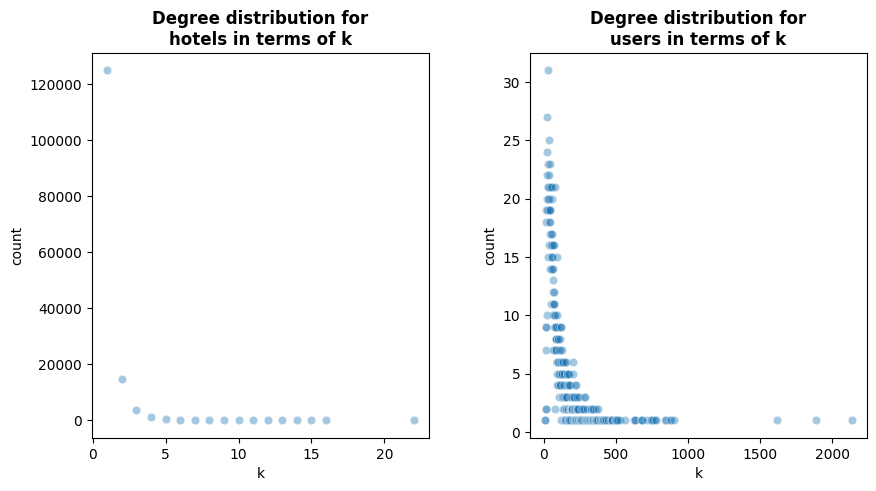

In [34]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [dd_hotel, dd_user], ["hotels", "users"]):
    sns.scatterplot(data=data, x="k", y="count", ax=ax, alpha=0.4)
    ax.set_title(f"Degree distribution for\n{which_category} in terms of k", weight = "bold")

# Save the plot
#if SAVE_FIG:
#    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_count.jpg")

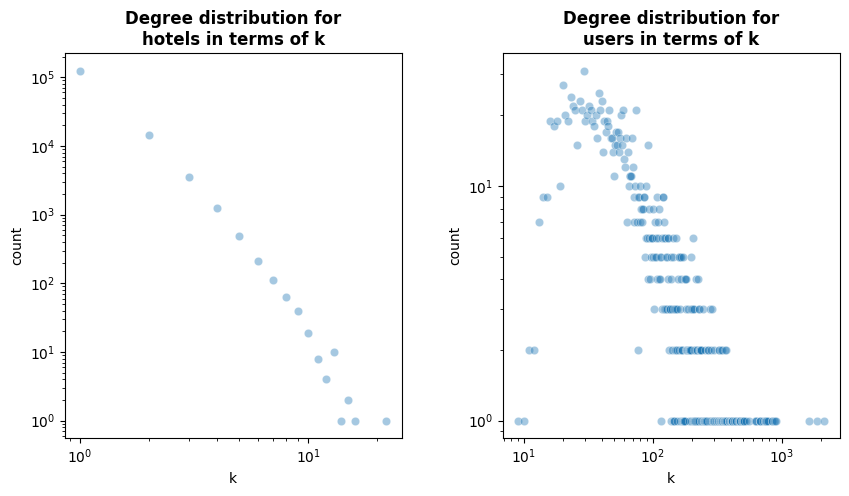

In [36]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [dd_hotel, dd_user], ["hotels", "users"]):
    sns.scatterplot(data=data, x="k", y="count", ax=ax, alpha=0.4)
    ax.set_title(f"Degree distribution for\n{which_category} in terms of k", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
#if SAVE_FIG:
#    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_count_loglog.jpg")

In [41]:
ccdf_user = dd_user.sort_values(by = 'k', ascending = False)
ccdf_user['cumsum'] = ccdf_user['count'].cumsum()
ccdf_user['ccdf'] = ccdf_user['cumsum'] / ccdf_user['count'].sum()
ccdf_user = ccdf_user[['k', 'ccdf']].sort_values(by = 'k')

In [42]:
ccdf_hotel = dd_hotel.sort_values(by = 'k', ascending = False)
ccdf_hotel['cumsum'] = ccdf_hotel['count'].cumsum()
ccdf_hotel['ccdf'] = ccdf_hotel['cumsum'] / ccdf_hotel['count'].sum()
ccdf_hotel = ccdf_hotel[['k', 'ccdf']].sort_values(by = 'k')

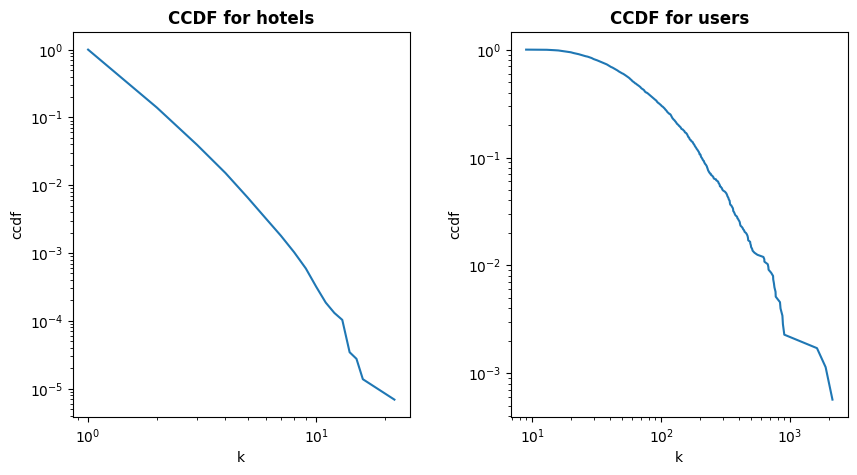

In [44]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [ccdf_hotel, ccdf_user], ["hotels", "users"]):
    sns.lineplot(data=data, x="k", y="ccdf", ax=ax)
    ax.set_title(f"CCDF for {which_category}", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
#if SAVE_FIG:
#    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_ccdf_loglog.jpg")

In [69]:
results_user = pl.Fit(ccdf_user["ccdf"])
k_min_user = ccdf_user[ccdf_user["ccdf"] == results_user.power_law.xmin]["k"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results_user.power_law.Kappa, results_user.power_law.alpha, k_min_user.iloc[0]))

ccdf_user["fit"] = (10 ** results_user.power_law.Kappa) * (ccdf_user["k"] ** -results_user.power_law.alpha)

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 11.3810 x ^ -2.1903 (k_min = 152)


In [68]:
results_user.power_law.xmin

0.17492877492877493

In [71]:
logcdf = np.log10(ccdf_user[["k", "ccdf"]])
x, y = logcdf['k'], logcdf['ccdf']

slope, log10intercept, r_value, p_value, std_err = linregress(x, y)
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

ccdf_user["fit"] = (10 ** log10intercept) * (ccdf_user["k"] ** (slope))

CCDF Fit: 130.8797 x ^ -1.3871 (R2 = 0.9092, p = 0.0000)


In [57]:
results_hotel = pl.Fit(ccdf_hotel["ccdf"])
k_min_hotel = ccdf_hotel[ccdf_hotel["ccdf"] == results_hotel.power_law.xmin]["k"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results_hotel.power_law.Kappa, results_hotel.power_law.alpha, k_min_hotel.iloc[0]))

ccdf_hotel["fit"] = (10 ** results_hotel.power_law.Kappa) * (ccdf_hotel["k"] ** -results_hotel.power_law.alpha)

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 11.4219 x ^ -1.2970 (k_min = 13)


In [75]:
logcdf = np.log10(ccdf_hotel[["k", "ccdf"]])
x, y = logcdf['k'], logcdf['ccdf']

slope, log10intercept, r_value, p_value, std_err = linregress(x, y)
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

ccdf_hotel["fit"] = (10 ** log10intercept) * (ccdf_hotel["k"] ** (slope))

CCDF Fit: 2.7932 x ^ -4.0534 (R2 = 0.9753, p = 0.0000)


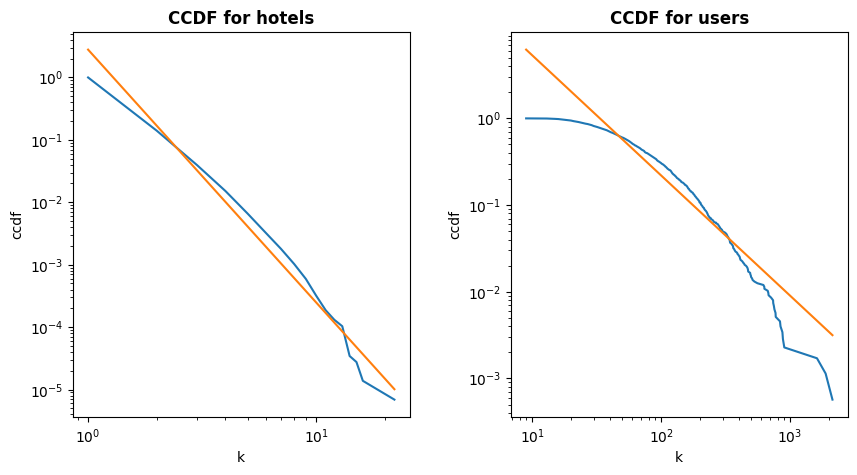

In [76]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [ccdf_hotel, ccdf_user], ["hotels", "users"]):
    sns.lineplot(data=data, x="k", y="ccdf", ax=ax)
    sns.lineplot(data=data, x='k', y='fit', ax=ax)
    ax.set_title(f"CCDF for {which_category}", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')